File loaded with latin1 encoding
Dataset shape: (541909, 8)

First few rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Data types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPric

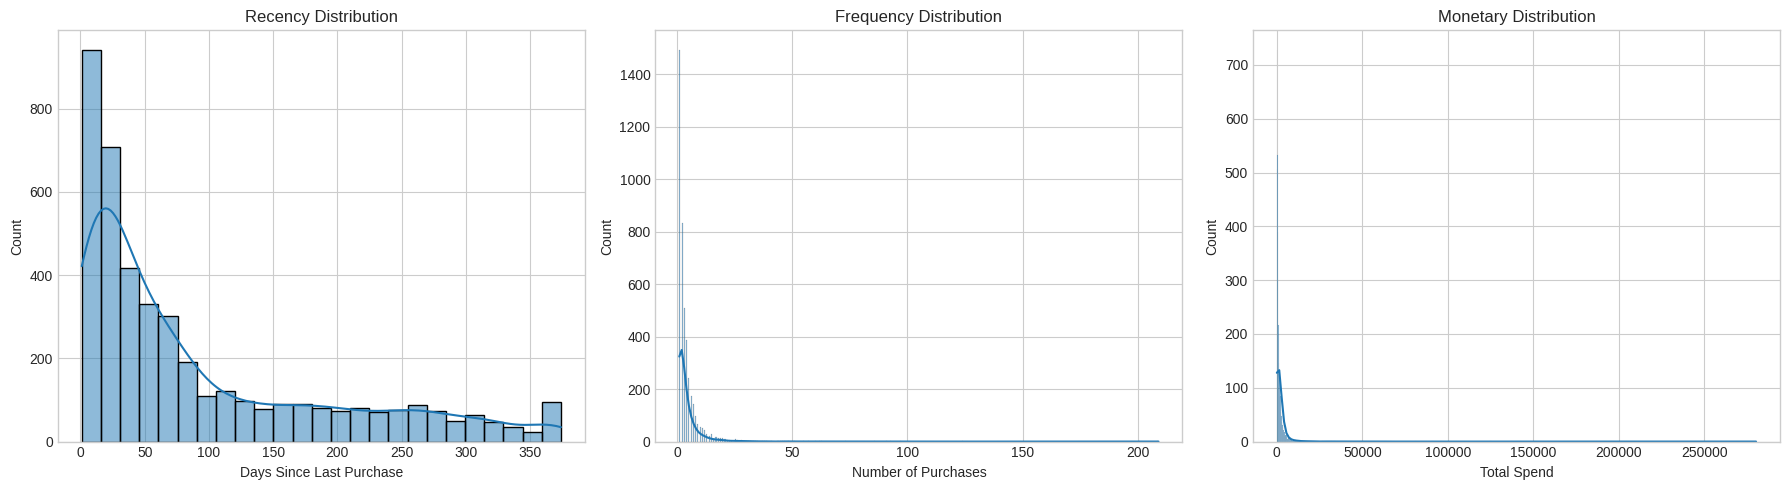


RFM scores and segments:
   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0       12346      326          1  77183.60        1        1        4   
1       12347        2          7   4310.00        4        4        4   
2       12348       75          4   1797.24        2        3        4   
3       12349       19          1   1757.55        3        1        4   
4       12350      310          1    334.40        1        1        2   
5       12352       36          8   2506.04        3        4        4   
6       12353      204          1     89.00        1        1        1   
7       12354      232          1   1079.40        1        1        3   
8       12355      214          1    459.40        1        1        2   
9       12356       23          3   2811.43        3        3        4   

   RFM_Score RFM_Segment  
0          6         114  
1         12         444  
2          9         234  
3          8         314  
4          4         112

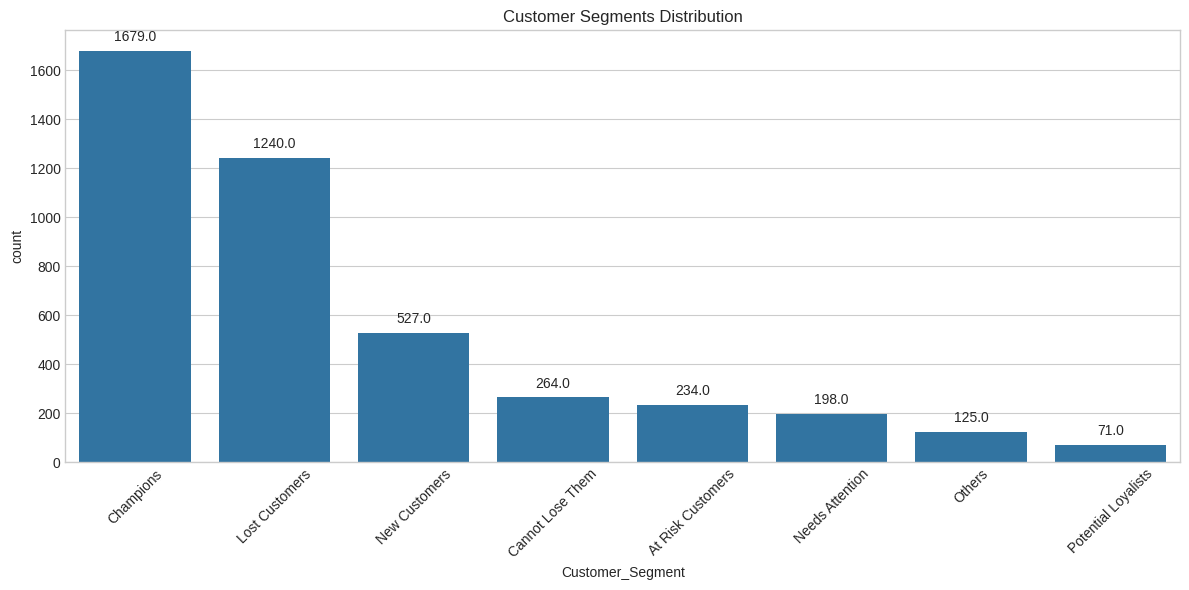


Average RFM values by segment:
               Segment  Avg_Recency  Avg_Frequency  Avg_Monetary  Count
0    At Risk Customers   124.273504       3.397436   1536.570556    234
1     Cannot Lose Them   148.522727       1.553030   1565.906292    264
2            Champions    25.451459       8.381775   4411.292228   1679
3       Lost Customers   194.671774       1.187097    285.280307   1240
4      Needs Attention   148.904040       3.010101    422.115157    198
5        New Customers    25.677419       1.356736    314.625047    527
6               Others    29.256000       2.816000    442.740000    125
7  Potential Loyalists    32.887324       1.676056   1034.016901     71


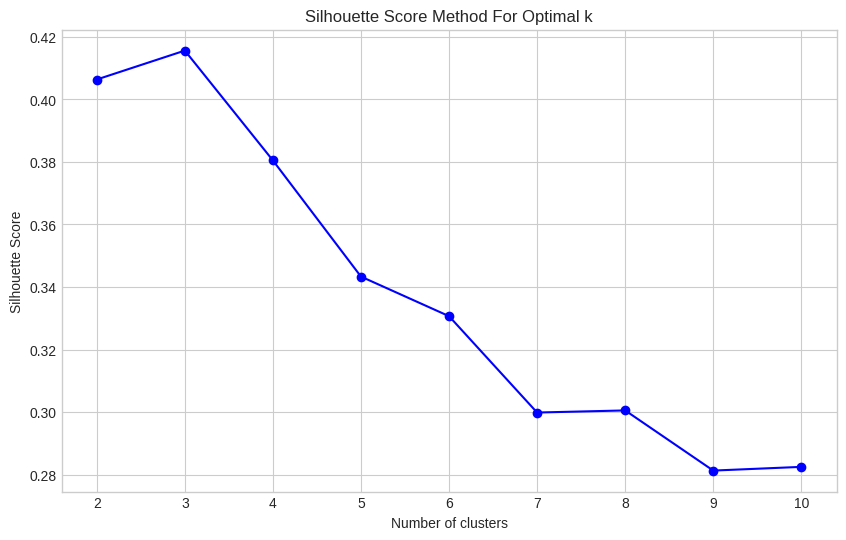

Optimal number of clusters: 3

Cluster statistics:
   Cluster  Avg_Recency  Avg_Frequency  Avg_Monetary  Count
0        0    54.857073       2.046169    615.235984   2036
1        1    30.100529       9.829932   5494.341156   1323
2        2   255.271706       1.390194    398.134924    979



Cross-tabulation of RFM segments and K-means clusters:
Cluster                0     1    2
Customer_Segment                   
At Risk Customers    158    38   38
Cannot Lose Them     167     5   92
Champions            399  1280    0
Lost Customers       467     0  773
Needs Attention      122     0   76
New Customers        527     0    0
Others               125     0    0
Potential Loyalists   71     0    0

Top 5 Champions:
      CustomerID  Recency  Frequency   Monetary  RFM_Score
4206       18109        2         26    8052.97         12
4201       18102        1         60  259657.30         12
34         12388       16          6    2780.66         12
1          12347        2          7    4310.00         12
4336       18283        4         16    2094.88         12


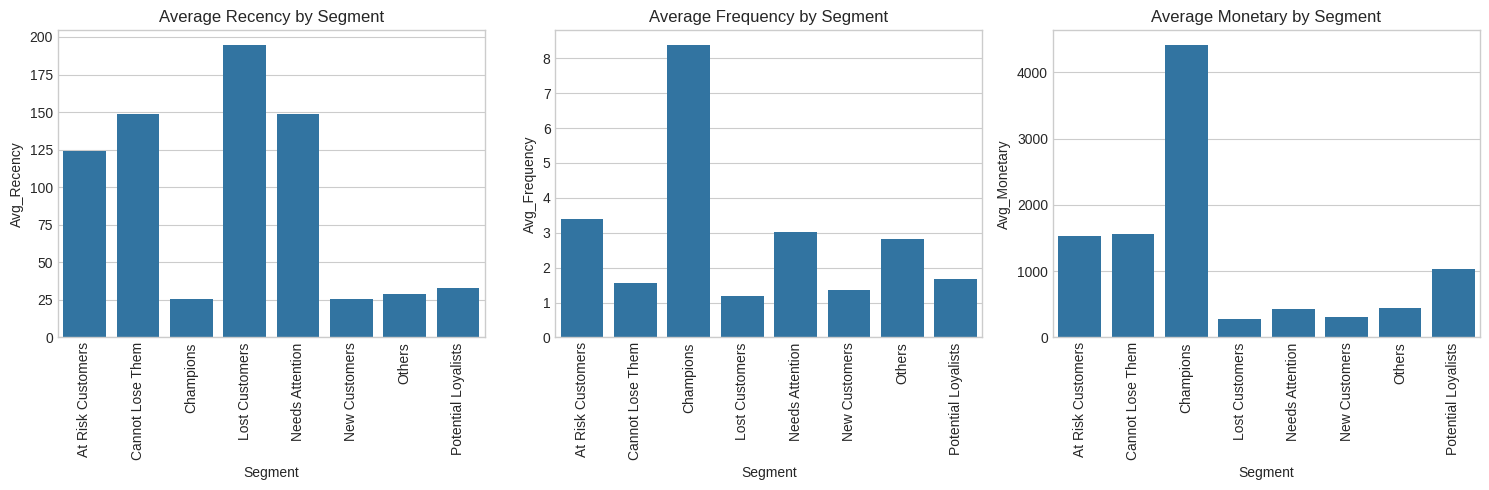


Results exported to 'rfm_customer_segments.csv'

Recommended strategies for each segment:
               Segment                                           Strategy
0            Champions  Reward them, make them feel valued, develop th...
1      Loyal Customers  Upsell higher value products, engage them, ask...
2  Potential Loyalists  Recommend related products, offer loyalty program
3        New Customers  Provide on-boarding support, offer early-user ...
4    At Risk Customers  Reactivate them, send personalized recommendat...
5      Needs Attention  Offer limited-time promotions, recommend popul...
6     Cannot Lose Them  Win back with targeted offers, build relationship
7       Lost Customers  Re-engage with relevant content, analyze reaso...


In [6]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set figure size
plt.rcParams['figure.figsize'] = (12, 8)
# Now we can use one of the available styles
plt.style.use('seaborn-v0_8-whitegrid')  # Using a style from the available list

# 2. Load and Explore Data
# Reading the data with encoding specification to handle special characters
try:
    # Try different encodings
    df = pd.read_csv('data.csv', encoding='latin1')
    print("File loaded with latin1 encoding")
except Exception:
    try:
        df = pd.read_csv('data.csv', encoding='ISO-8859-1')
        print("File loaded with ISO-8859-1 encoding")
    except Exception:
        try:
            df = pd.read_csv('data.csv', encoding='cp1252')
            print("File loaded with cp1252 encoding")
        except Exception as e:
            print(f"Error loading file: {e}")
            # If all else fails, try loading with error handling
            df = pd.read_csv('data.csv', encoding='latin1', error_bad_lines=False)

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Check data types and missing values
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# 3. Data Cleaning and Preprocessing
# Convert CustomerID to string to handle missing values better
df['CustomerID'] = df['CustomerID'].astype('str')

# Remove rows with missing CustomerID (we need this for customer segmentation)
df_clean = df[df['CustomerID'] != 'nan'].copy()

# Convert CustomerID back to numeric
df_clean['CustomerID'] = df_clean['CustomerID'].astype(float).astype(int)

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Filter out cancelled orders (those starting with 'C')
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Calculate total price for each transaction
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Filter out potential outliers or errors
df_clean = df_clean[df_clean['Quantity'] > 0]  # Remove negative quantities
df_clean = df_clean[df_clean['UnitPrice'] > 0]  # Remove zero or negative prices

# Display summary after cleaning
print("\nDataset shape after cleaning:", df_clean.shape)
print("\nSummary statistics for cleaned data:")
print(df_clean.describe())

# 4. RFM Analysis
# Set the snapshot date (last date in the dataset + 1 day)
snapshot_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
print(f"\nSnapshot date: {snapshot_date}")

# Calculate RFM metrics for each customer
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalPrice': 'sum'                                      # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display RFM summary
print("\nRFM summary statistics:")
print(rfm.describe())

# Plot the distributions of R, F, and M
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], kde=True)
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], kde=True)
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], kde=True)
plt.title('Monetary Distribution')
plt.xlabel('Total Spend')

plt.tight_layout()
plt.show()

# 5. RFM Scoring
# Create quartiles for RFM metrics
# Note: For Recency, lower values are better (1 is best, 4 is worst)
# For Frequency and Monetary, higher values are better (4 is best, 1 is worst)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4])

# Convert R, F, M scores to integers for calculations
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Calculate RFM Score (sum of R, F, M scores)
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Create RFM Segment using string concatenation of RFM values
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display RFM scoring results
print("\nRFM scores and segments:")
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'RFM_Segment']].head(10))

# 6. Customer Segmentation Based on RFM Score
# Define segmentation function
def segment_customer(row):
    if row['RFM_Score'] >= 9:
        return 'Champions'
    elif (row['R_Score'] >= 3) and (row['F_Score'] >= 3) and (row['M_Score'] >= 3):
        return 'Loyal Customers'
    elif (row['R_Score'] >= 3) and (row['F_Score'] <= 2) and (row['M_Score'] >= 3):
        return 'Potential Loyalists'
    elif (row['R_Score'] >= 3) and (row['F_Score'] <= 2) and (row['M_Score'] <= 2):
        return 'New Customers'
    elif (row['R_Score'] <= 2) and (row['F_Score'] >= 3) and (row['M_Score'] >= 3):
        return 'At Risk Customers'
    elif (row['R_Score'] <= 2) and (row['F_Score'] >= 3) and (row['M_Score'] <= 2):
        return 'Needs Attention'
    elif (row['R_Score'] <= 2) and (row['F_Score'] <= 2) and (row['M_Score'] >= 3):
        return 'Cannot Lose Them'
    elif (row['R_Score'] <= 2) and (row['F_Score'] <= 2) and (row['M_Score'] <= 2):
        return 'Lost Customers'
    else:
        return 'Others'

# Apply the segmentation function
rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)

# Display segment distribution
segment_counts = rfm['Customer_Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']
print("\nCustomer segments distribution:")
print(segment_counts)

# Visualize customer segments
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Customer_Segment', data=rfm, order=segment_counts['Segment'])
plt.title('Customer Segments Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

# Calculate average RFM values for each segment
segment_rfm = rfm.groupby('Customer_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()
segment_rfm.columns = ['Segment', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']
print("\nAverage RFM values by segment:")
print(segment_rfm)

# 7. K-Means Clustering
# Prepare data for clustering
# Apply log transformation to handle skewness in Frequency and Monetary
rfm_for_clustering = rfm[['Recency', 'Frequency', 'Monetary']].copy()
rfm_for_clustering['Frequency_Log'] = np.log1p(rfm_for_clustering['Frequency'])
rfm_for_clustering['Monetary_Log'] = np.log1p(rfm_for_clustering['Monetary'])

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering[['Recency', 'Frequency_Log', 'Monetary_Log']])

# Find optimal number of clusters using silhouette score
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method For Optimal k')
plt.grid(True)
plt.show()

# Get optimal k value
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_k}")

# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 8. Analyze Clusters
# Calculate cluster statistics
cluster_stats = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()
cluster_stats.columns = ['Cluster', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']
print("\nCluster statistics:")
print(cluster_stats)

# Visualize clusters
# 3D scatter plot of clusters
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary',
                   color='Cluster', hover_name='CustomerID',
                   opacity=0.8, title='3D Cluster Visualization')
fig.update_layout(scene = dict(
                    xaxis_title='Recency',
                    yaxis_title='Frequency',
                    zaxis_title='Monetary'),
                 )
fig.show()

# Compare RFM segments with K-means clusters
segment_cluster_crosstab = pd.crosstab(rfm['Customer_Segment'], rfm['Cluster'])
print("\nCross-tabulation of RFM segments and K-means clusters:")
print(segment_cluster_crosstab)

# 9. Business Insights and Recommendations
# Display top customers from each segment
def get_top_customers(segment, n=5):
    segment_customers = rfm[rfm['Customer_Segment'] == segment].sort_values('RFM_Score', ascending=False)
    return segment_customers.head(n)

# Example for Champions segment
champions = get_top_customers('Champions')
print("\nTop 5 Champions:")
print(champions[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']])

# Plot segment characteristics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='Segment', y='Avg_Recency', data=segment_rfm)
plt.title('Average Recency by Segment')
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.barplot(x='Segment', y='Avg_Frequency', data=segment_rfm)
plt.title('Average Frequency by Segment')
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.barplot(x='Segment', y='Avg_Monetary', data=segment_rfm)
plt.title('Average Monetary by Segment')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# 10. Export Results
# Export RFM results with segments and clusters
rfm.to_csv('rfm_customer_segments.csv', index=False)
print("\nResults exported to 'rfm_customer_segments.csv'")

# Recommended strategies for each segment
recommendations = pd.DataFrame([
    {'Segment': 'Champions', 'Strategy': 'Reward them, make them feel valued, develop them as brand advocates'},
    {'Segment': 'Loyal Customers', 'Strategy': 'Upsell higher value products, engage them, ask for reviews'},
    {'Segment': 'Potential Loyalists', 'Strategy': 'Recommend related products, offer loyalty program'},
    {'Segment': 'New Customers', 'Strategy': 'Provide on-boarding support, offer early-user incentives'},
    {'Segment': 'At Risk Customers', 'Strategy': 'Reactivate them, send personalized recommendations'},
    {'Segment': 'Needs Attention', 'Strategy': 'Offer limited-time promotions, recommend popular products'},
    {'Segment': 'Cannot Lose Them', 'Strategy': 'Win back with targeted offers, build relationship'},
    {'Segment': 'Lost Customers', 'Strategy': 'Re-engage with relevant content, analyze reasons for churn'}
])

print("\nRecommended strategies for each segment:")
print(recommendations)